<a href="https://colab.research.google.com/github/dafrie/fin-disclosures-nlp/blob/master/notebooks/CRO_Classification_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRO Classification with Transformers



# Setup

In [ ]:
try:
  import google.colab
  is_running_in_colab = True
except:
  is_running_in_colab = False

if is_running_in_colab:
  # Load Google drive where the data and models are stored
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
############################## CONFIG ##############################
# Task config
TASK = "binary" #@param ["multi-label", "binary"]
CATEGORY_LEVEL = 'cro_sub_type_combined' #@param ["cro", "cro_sub_type_combined"]

# Dataset config
FILTER_OP = True #@param { type: "boolean"}
SCENARIO = "realistic" #@param [ "optimistic", "efficient-realistic", "realistic"]

# Evaluation metric config. See for context: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
AVERAGING_STRATEGY = 'macro' #@param ["micro",  "macro", "weighted"]

RESULTS_FILE_NAME = f"{CATEGORY_LEVEL}_{TASK}_results.csv"

# To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
SEED_VALUE = 42

###########################

# Set to true if fine-tuning should be enabled. Else it loads fine-tuned model
ENABLE_FINE_TUNING = True #@param {type:"boolean"}

# See list here: https://huggingface.co/models
MODEL_NAME = 'distilbert-base-uncased' #@param ["bert-base-uncased", "bert-large-uncased", "albert-base-v2", "albert-large-v2", "albert-xlarge-v2", "albert-xxlarge-v2", "roberta-base", "roberta-large", "distilbert-base-uncased", "distilbert-base-cased", "xlnet-base-cased", "xlnet-large-cased"]

# The DataLoader needs to know our batch size for training. BERT Authors recommend 16 or 32, however this leads to an error due to not enough GPU memory
BATCH_SIZE = 8 #@param ["8", "16", "32"] {type:"raw"}
MAX_TOKEN_SIZE = 256 #@param [512,256,128] {type:"raw"}
EPOCHS = 2 # @param [1,2,3,4] {type:"raw"}
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0

# Enable comet-ml logging
DISABLE_COMET_ML = True #@param {type:"boolean"}
SHOULD_HYPERPARAMETER_SEARCH = False #@param {type:"boolean"}
####################################################################
LOCAL_DIR = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/"
COLAB_DIR = "/content/drive/MyDrive/fin-disclosures-nlp"

if SCENARIO == "optimistic":
  TRAIN_NEG_SAMPLING_STRATEGY = "None"
  TEST_NEG_SAMPLING_STRATEGY = "None"

elif SCENARIO == "efficient-realistic":
  TRAIN_NEG_SAMPLING_STRATEGY = "only_OP"
  TEST_NEG_SAMPLING_STRATEGY = "all"

elif SCENARIO == "realistic":
  TRAIN_NEG_SAMPLING_STRATEGY = "all"
  TEST_NEG_SAMPLING_STRATEGY = "all"

parameters = {
    "task": TASK,
    "category_level": CATEGORY_LEVEL,
    "scenario": SCENARIO,
    "enable_fine_tuning": ENABLE_FINE_TUNING,
    "model_type": "transformer",
    "model_name": MODEL_NAME,
    "batch_size": BATCH_SIZE,
    "max_token_size": MAX_TOKEN_SIZE,
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "seed_value": SEED_VALUE,
}

In [ ]:
if is_running_in_colab:
  # Install transformers library + datasets helper
  !pip install transformers --quiet &> /dev/null
  !pip install datasets --quiet &> /dev/null
  !pip install optuna --quiet &> /dev/null

  # Latex for output
  ! apt install texlive-latex-recommended -qq &> /dev/null
  ! apt install texlive-latex-extra -qq &> /dev/null
  ! apt install dvipng -qq &> /dev/null
  ! apt install cm-super -qq &> /dev/null

  # Load repository

  !git clone https://github.com/dafrie/fin-disclosures-nlp.git    
  %cd /content/fin-disclosures-nlp
  !git pull

%load_ext autoreload
%autoreload 2

# Load repository utils
import sys
import os
sys.path.append('..')

from data import constants
from data import cro_dataset
from data import evaluation
from data import cro_transformer_models

DIR = COLAB_DIR if is_running_in_colab else LOCAL_DIR
DATA_DIR = os.path.join(DIR, "data", "labels")
MODELS_DIR = os.path.join(DIR, "models", parameters["model_type"])
RESULTS_DIR = os.path.join(DIR, 'results')
RESULTS_FILE_PATH = os.path.join(RESULTS_DIR, RESULTS_FILE_NAME)

Cloning into 'fin-disclosures-nlp'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 444 (delta 236), reused 266 (delta 120), pack-reused 41
Receiving objects: 100% (444/444), 79.98 MiB | 18.90 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/fin-disclosures-nlp
Already up to date.


In [ ]:
# Initialize comet-ml
!pip install comet-ml --quiet

import configparser
from comet_ml import Experiment

config = configparser.ConfigParser()
config.read('/content/drive/My Drive/secrets/secrets.ini')

API_KEY = config.get('default', 'COMET_ML_API_KEY')
PROJ_NAME = "fin-disclosures-nlp"
WORKSPACE = "dafrie" # comet-ml username
experiment = Experiment(api_key=API_KEY,project_name=PROJ_NAME, workspace=WORKSPACE, disabled=DISABLE_COMET_ML)
experiment.log_parameters(parameters)

     |████████████████████████████████| 245kB 12.6MB/s 
     |████████████████████████████████| 204kB 18.7MB/s 
     |████████████████████████████████| 512kB 22.6MB/s 


In [ ]:
model_id = SCENARIO + "_" + MODEL_NAME + "_" + CATEGORY_LEVEL
print(f"Selected {MODEL_NAME} as transformer model for the task to classification of {CATEGORY_LEVEL}...")

# Setup the models path
expected_model_path = os.path.join(MODELS_DIR, TASK, model_id)
has_model_path = os.path.isdir(expected_model_path)
model_checkpoint = MODEL_NAME if ENABLE_FINE_TUNING else expected_model_path

# Check if model exists
if not ENABLE_FINE_TUNING:
  assert has_model_path, f"No fine-tuned model found at '{expected_model_path}', you need first to fine-tune a model from a pretrained checkpoint by enabling the 'ENABLE_FINE_TUNING' flag!"


Selected distilbert-base-uncased as transformer model for the task to classification of cro_sub_type_combined...


# Load data

In [ ]:
# Load/Initialize results file
results = evaluation.Results(RESULTS_FILE_PATH, parameters)

In [ ]:
dataset = cro_dataset.prepare_datasets(
    data_dir=DATA_DIR,
    task=TASK, 
    cro_category_level=CATEGORY_LEVEL ,
    should_filter_op=FILTER_OP,
    validation_split=0.1,
    train_neg_sampling_strategy=None if TRAIN_NEG_SAMPLING_STRATEGY == 'None' else TRAIN_NEG_SAMPLING_STRATEGY,
    test_neg_sampling_strategy=None if TEST_NEG_SAMPLING_STRATEGY == 'None' else TEST_NEG_SAMPLING_STRATEGY,
    seed_value=SEED_VALUE,
    as_huggingface_ds=True,
)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 25029
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 28209
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 2782
    })
})


# Training

In [ ]:
trainer = cro_transformer_models.CroTrainer(
    model_checkpoint=model_checkpoint,
    dataset=dataset,
    task=TASK,
    avg_strategy=AVERAGING_STRATEGY,
    max_token_size=256,
    # TrainerArguments
    output_dir=f"/content/models/{TASK}/{model_id}",
    evaluation_strategy = "epoch",
    learning_rate = LEARNING_RATE,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = EPOCHS,
    weight_decay = WEIGHT_DECAY,
    load_best_model_at_end = True,
    metric_for_best_model = "pr_auc" if TASK == "multi-label" else "matthews_correlation",
    greater_is_better = True,
    seed = SEED_VALUE,
)

# Only train if enabled, else we just want to load the model
if ENABLE_FINE_TUNING:
  trainer.train()
  # TODO: Make sure that the "best" model is loaded afterwards
  # TODO: Clear checkpoints
  trainer.save_model()

Using weights: tensor([ 0.5052, 48.8848], device='cuda:0')



Tokenization....


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1,Precision,Recall,Matthews Correlation
1,0.188782,0.032926,0.993889,0.497826,0.780513,0.821540,0.748913,0.565811
2,0.117094,0.025430,0.994968,0.679282,0.839641,0.839641,0.839641,0.679282


In [ ]:
eval_metrics = trainer.evaluate()
experiment.log_metrics(eval_metrics)
results.log_experiment(eval_metrics)

if SHOULD_HYPERPARAMETER_SEARCH:
  best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")
  best_run
  for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)
  trainer.train()

# Store the model
trainer.save_model(expected_model_path)

In [ ]:
 from transformers import AutoTokenizer
 # Set and load the tokenizer.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize the dataset
dataset = dataset.map(lambda ds: tokenizer(ds["text"], truncation=True, padding='max_length', max_length=256), batched=True)

In [ ]:
# Get predictions of overall dataset for threshold
train_predictions = trainer.predict(dataset['train'])

,ROC AuC,PR AuC
0,0.985864,0.858841


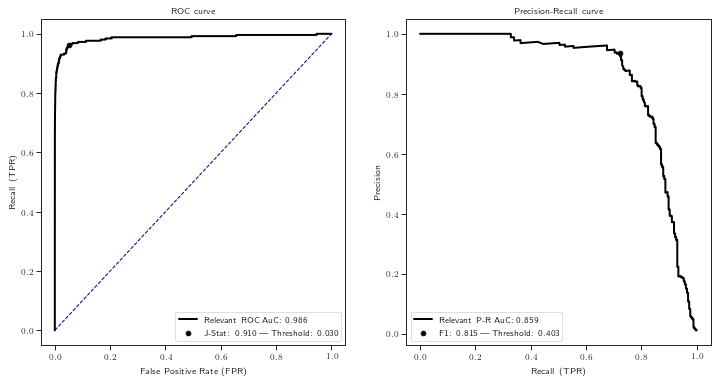

In [ ]:
import pandas as pd
from scipy.special import expit

train_preds = train_predictions.predictions
train_preds_prob = expit(train_preds)
train_labels = train_predictions.label_ids

if TASK == 'binary':
  train_labels = pd.Series(train_labels)

else:
  train_labels = pd.DataFrame(train_labels, columns=dataset['train'].features['labels'].feature.names)

train_threshold_moving_report = os.path.join(RESULTS_DIR, "figures", f"{CATEGORY_LEVEL}_{TASK}_{SCENARIO}_{MODEL_NAME}_train_threshold.pdf")
train_eval_scores, best_roc_threshold, best_pr_threshold = evaluation.threshold_moving_report(train_labels, train_preds_prob, export_path=train_threshold_moving_report)
results.log_experiment(train_eval_scores, prefix="train")
results.log_experiment({"epochs": parameters["epochs"]})
results.log_experiment({ "best_pr_threshold": best_pr_threshold.values(), "best_roc_threshold": best_roc_threshold.values()}, prefix="train")
train_eval_scores

In [ ]:
# Get predictions of test dataset
test_predictions = trainer.predict(dataset['test'])

Using threshold values dict_values([0.40330723])
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28155
           1       0.43      0.56      0.48        54

    accuracy                           1.00     28209
   macro avg       0.71      0.78      0.74     28209
weighted avg       1.00      1.00      1.00     28209



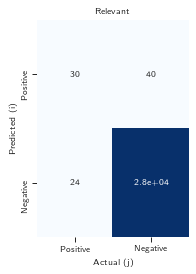

,ROC AuC,PR AuC,F1,Report,CMS
0,0.987862,0.475577,0.483871,"{""1"": {""precision"": 0.42857142857142855, ""reca...","[[[30, 40], [24, 28115]]]"


In [ ]:
# Evaluate test
test_preds = test_predictions.predictions
test_preds_prob = expit(test_preds)
test_labels = test_predictions.label_ids

if TASK == 'binary':
  test_labels = pd.Series(test_labels)

else:
  test_labels = pd.DataFrame(test_labels, columns=dataset['test'].features['labels'].feature.names)

test_evaluation_report = os.path.join(RESULTS_DIR, "figures", f"{CATEGORY_LEVEL}_{TASK}_{SCENARIO}_{MODEL_NAME}_test_evaluation.pdf")
test_eval_scores = evaluation.test_evaluation_report(test_labels, test_preds_prob, best_pr_threshold.values(), export_path=test_evaluation_report)
results.log_experiment(test_eval_scores, prefix="test")
test_eval_scores